In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import plotly.express as px


### 전처리

In [2]:
data = pd.read_csv('/Users/sb/Desktop/project/restaurant type recsys/data/V8.csv')
data

,name,restaurant,content,type,address,date,type2,type_dict,name_dict
0,keem,토리아에즈 방이점,맛있어서 몇일만에 재방문이요\n,이자카야,서울특별시 송파구 방이동,11.28.화,주점,1,1
1,keem,토리아에즈 방이점,예전부터 다른 지점 방문하고 싶었는데\n근처에 생겨서 다녀왔어요\n맛있네요!,이자카야,서울특별시 송파구 방이동,11.24.금,주점,1,1
2,keem,송파와인집,매달 추천와인이있어서 좋아요\n간만에 화이트 와인이 땡겨서 화이트2 레드1세트로 구...,주류,서울특별시 송파구 석촌동,11.12.일,주점,2,1
3,keem,명동교자 이태원점,날씨가 추워져서 뜨끈한 칼국수 먹으러 방문했어요\n맛이 변함없이 좋고 마늘김치도 역...,"칼국수,만두",서울특별시 용산구 이태원동,11.12.일,한식,3,1
4,keem,진구정,사장님이 오픈하는곳은 무조건 가봐야져\n평냉에 비냉 제육까지 잘 먹었습니다\n제육에...,이북음식,서울특별시 광진구 구의동,11.11.토,한식,4,1
...,...,...,...,...,...,...,...,...,...
116684,cnswkd,익선잡방,음식도 맛있거 분위기도 좋았어요,브런치,서울특별시 종로구 익선동,22.7.7.목,브런치,37,9526
116685,cnswkd,화포식당 가재울뉴타운점,고기 구워주신분들 너무 친절하시고 맛있게 구워주세요 육즙 장난 아니예요😋,돼지고기구이,서울특별시 서대문구 남가좌동,22.6.27.월,고기,44,9526
116686,cnswkd,화포식당 연신내점,자주 오는 곳인데 올때마다 너무 맛있어요😋\n직원분들도 너무 친절하시고\n고기도 맛...,돼지고기구이,서울특별시 은평구 갈현동,22.5.7.토,고기,44,9526
116687,cnswkd,화포식당 가재울뉴타운점,고기 육질도 좋고 맛도 좋아요\n무엇보다 너무 잘 구워주셔서 맛있었어요😋\n소스가 ...,돼지고기구이,서울특별시 서대문구 남가좌동,22.3.27.일,고기,44,9526


In [3]:
group_data = data.copy()

# for pad:0 mask:1 start type_dict from 2
type_mapping = {type:idx+2 for idx,type in enumerate(group_data['type'].unique())}

# start name_dict from 0
name_mapping = {name_dict:idx+1 for idx,name_dict in enumerate(group_data['name'].unique())}

In [4]:
group_data['type_dict'] = group_data['type'].map(type_mapping)
group_data['name_dict'] = group_data['name'].map(name_mapping)
group_data

,name,restaurant,content,type,address,date,type2,type_dict,name_dict
0,keem,토리아에즈 방이점,맛있어서 몇일만에 재방문이요\n,이자카야,서울특별시 송파구 방이동,11.28.화,주점,2,1
1,keem,토리아에즈 방이점,예전부터 다른 지점 방문하고 싶었는데\n근처에 생겨서 다녀왔어요\n맛있네요!,이자카야,서울특별시 송파구 방이동,11.24.금,주점,2,1
2,keem,송파와인집,매달 추천와인이있어서 좋아요\n간만에 화이트 와인이 땡겨서 화이트2 레드1세트로 구...,주류,서울특별시 송파구 석촌동,11.12.일,주점,3,1
3,keem,명동교자 이태원점,날씨가 추워져서 뜨끈한 칼국수 먹으러 방문했어요\n맛이 변함없이 좋고 마늘김치도 역...,"칼국수,만두",서울특별시 용산구 이태원동,11.12.일,한식,4,1
4,keem,진구정,사장님이 오픈하는곳은 무조건 가봐야져\n평냉에 비냉 제육까지 잘 먹었습니다\n제육에...,이북음식,서울특별시 광진구 구의동,11.11.토,한식,5,1
...,...,...,...,...,...,...,...,...,...
116684,cnswkd,익선잡방,음식도 맛있거 분위기도 좋았어요,브런치,서울특별시 종로구 익선동,22.7.7.목,브런치,38,9526
116685,cnswkd,화포식당 가재울뉴타운점,고기 구워주신분들 너무 친절하시고 맛있게 구워주세요 육즙 장난 아니예요😋,돼지고기구이,서울특별시 서대문구 남가좌동,22.6.27.월,고기,45,9526
116686,cnswkd,화포식당 연신내점,자주 오는 곳인데 올때마다 너무 맛있어요😋\n직원분들도 너무 친절하시고\n고기도 맛...,돼지고기구이,서울특별시 은평구 갈현동,22.5.7.토,고기,45,9526
116687,cnswkd,화포식당 가재울뉴타운점,고기 육질도 좋고 맛도 좋아요\n무엇보다 너무 잘 구워주셔서 맛있었어요😋\n소스가 ...,돼지고기구이,서울특별시 서대문구 남가좌동,22.3.27.일,고기,45,9526


In [5]:
grouped_df = group_data.groupby('name_dict').agg({'type_dict': list, 'type': list}).reset_index()
grouped_df['sequence'] = grouped_df['type_dict'].apply(lambda x: ' '.join(map(str, x)))
grouped_df['sequence_converted'] = grouped_df['type'].apply(lambda x: ' '.join(map(str, x)))

result_df = grouped_df[['name_dict', 'sequence', 'sequence_converted']]
result_df

,name_dict,sequence,sequence_converted
0,1,2 2 3 4 5 6 8 76 83 22 16 7 56 11 57 6 83 69 8...,"이자카야 이자카야 주류 칼국수,만두 이북음식 김밥 한식 패밀리레스토랑 냉면 양식 와..."
1,2,7 7 7 8 9 10 11 19 11 11 20 20 21 15 11 31 4 2...,"육류,고기요리 육류,고기요리 육류,고기요리 한식 아귀찜,해물찜 치킨,닭강정 멕시코,..."
2,3,12 13 14 10 15 16 69 27 35 38 36 51 4 61 51 38...,"양꼬치 찌개,전골 중식당 치킨,닭강정 일식당 와인 오리요리 곱창,막창,양 햄버거 브..."
3,4,11 11 17 18 7 7 45 40 54 15 7 2 45 20 15 34 35...,"멕시코,남미음식 멕시코,남미음식 태국음식 족발,보쌈 육류,고기요리 육류,고기요리 돼..."
4,5,14 22 15 35 14 24 8 50 26 27 56 22 27 27 34 7 ...,"중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창,막창,양 해물,..."
...,...,...,...
9521,9522,22 63 53 53 37 53 48 45 15 45 45 45 45 19,양식 닭갈비 국밥 국밥 마라탕 국밥 샤브샤브 돼지고기구이 일식당 돼지고기구이 돼지고...
9522,9523,23 10 4 22 15 10 106 10 35 24 22,"일본식라면 치킨,닭강정 칼국수,만두 양식 일식당 치킨,닭강정 딤섬,중식만두 치킨,닭..."
9523,9524,14 35 35 93 43 58,"중식당 햄버거 햄버거 토스트 우동,소바 한정식"
9524,9525,7 22 28 15 45 15,"육류,고기요리 양식 베트남음식 일식당 돼지고기구이 일식당"


In [6]:
def string_to_numeric_list(s):
    return [int(num) for num in s.split()]

result_df['sequence_numeric'] = result_df['sequence'].apply(string_to_numeric_list)


/var/folders/yn/ptj4__w518v924c18l9flhhw0000gn/T/ipykernel_5464/2378679587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['sequence_numeric'] = result_df['sequence'].apply(string_to_numeric_list)


In [7]:
result_df.drop(columns = ['sequence'])

,name_dict,sequence_converted,sequence_numeric
0,1,"이자카야 이자카야 주류 칼국수,만두 이북음식 김밥 한식 패밀리레스토랑 냉면 양식 와...","[2, 2, 3, 4, 5, 6, 8, 76, 83, 22, 16, 7, 56, 1..."
1,2,"육류,고기요리 육류,고기요리 육류,고기요리 한식 아귀찜,해물찜 치킨,닭강정 멕시코,...","[7, 7, 7, 8, 9, 10, 11, 19, 11, 11, 20, 20, 21..."
2,3,"양꼬치 찌개,전골 중식당 치킨,닭강정 일식당 와인 오리요리 곱창,막창,양 햄버거 브...","[12, 13, 14, 10, 15, 16, 69, 27, 35, 38, 36, 5..."
3,4,"멕시코,남미음식 멕시코,남미음식 태국음식 족발,보쌈 육류,고기요리 육류,고기요리 돼...","[11, 11, 17, 18, 7, 7, 45, 40, 54, 15, 7, 2, 4..."
4,5,"중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창,막창,양 해물,...","[14, 22, 15, 35, 14, 24, 8, 50, 26, 27, 56, 22..."
...,...,...,...
9521,9522,양식 닭갈비 국밥 국밥 마라탕 국밥 샤브샤브 돼지고기구이 일식당 돼지고기구이 돼지고...,"[22, 63, 53, 53, 37, 53, 48, 45, 15, 45, 45, 4..."
9522,9523,"일본식라면 치킨,닭강정 칼국수,만두 양식 일식당 치킨,닭강정 딤섬,중식만두 치킨,닭...","[23, 10, 4, 22, 15, 10, 106, 10, 35, 24, 22]"
9523,9524,"중식당 햄버거 햄버거 토스트 우동,소바 한정식","[14, 35, 35, 93, 43, 58]"
9524,9525,"육류,고기요리 양식 베트남음식 일식당 돼지고기구이 일식당","[7, 22, 28, 15, 45, 15]"


In [8]:
result_df['sequence_numeric'].apply(len).max()

30

## embedding with pretrained

In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

In [10]:
embeddings = model.encode(result_df['sequence_numeric'])

In [11]:
embeddings_dataframe = pd.DataFrame(embeddings)
embeddings_dataframe

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.055219,-0.027182,-0.093654,0.067561,-0.028725,-0.095101,0.130468,0.053372,-0.002696,-0.049684,...,0.052604,0.011254,0.016152,0.017377,0.014709,-0.003851,0.103137,0.058261,-0.022665,-0.004131
1,-0.047353,0.033556,-0.035691,0.104117,-0.032209,0.006905,0.107750,0.039097,-0.052621,-0.040321,...,0.104948,-0.009621,0.024757,-0.006246,-0.037639,0.014298,0.069454,0.017149,-0.043922,0.015852
2,-0.039561,0.077577,-0.086612,0.003467,-0.053542,0.001746,0.066006,0.020187,-0.011388,-0.033067,...,0.113042,-0.010878,0.016887,0.015077,-0.047186,0.059852,0.149986,-0.006588,-0.035404,-0.015241
3,-0.112254,0.042806,-0.087756,-0.018443,-0.009697,0.031557,0.068730,0.026291,-0.049494,-0.059011,...,-0.006619,0.013584,0.004973,-0.020616,-0.039100,0.086319,0.122241,0.032851,-0.084419,-0.018097
4,-0.026361,0.119380,-0.072587,0.062591,-0.053944,0.046454,0.058190,0.074806,-0.002537,-0.060694,...,0.085621,0.008919,-0.002757,0.033084,0.011017,0.007235,0.171006,-0.004312,-0.092422,-0.043309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9521,0.018022,0.127800,-0.107326,0.093262,-0.072199,0.070416,0.022497,0.055839,-0.025470,-0.080897,...,0.023626,0.023042,0.009459,0.009969,-0.033025,0.005396,0.163112,-0.034191,-0.053544,-0.050188
9522,-0.032195,0.061489,-0.069790,0.047129,0.001635,0.077215,0.060944,0.070135,-0.067524,-0.083702,...,0.034850,0.030595,0.010308,0.008734,-0.009608,0.053501,0.120795,-0.005753,-0.061662,-0.065096
9523,-0.034921,0.098746,-0.092390,0.045393,-0.067223,-0.010908,0.073708,0.079715,-0.058576,-0.015544,...,0.092945,-0.006835,0.059419,0.033132,-0.002809,-0.024639,0.100580,-0.064972,-0.070651,-0.019084
9524,0.008956,0.099500,-0.070148,0.088328,-0.050623,0.061940,0.051334,0.065086,-0.018852,-0.059682,...,0.066908,0.002234,-0.010663,0.014268,0.003900,0.005165,0.126083,-0.013200,-0.094017,-0.041218


In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0)
data_tsne = tsne.fit_transform(embeddings_dataframe)

data_tsne.shape

(9526, 2)

### KNN + tSNE

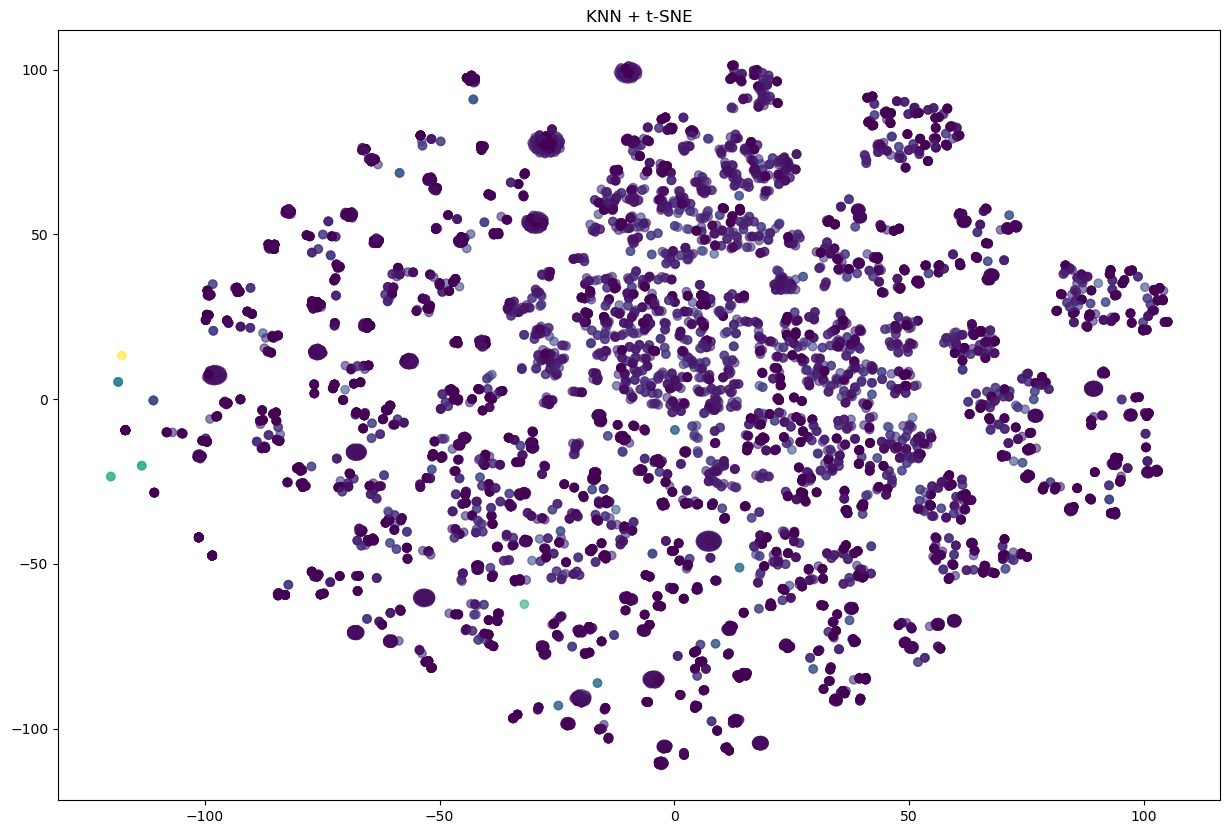

In [13]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

knn = NearestNeighbors(n_neighbors=5) 
knn.fit(data_tsne)
distances, indices = knn.kneighbors(data_tsne)

# 시각화를 위한 설정
plt.figure(figsize=(15, 10))

# 각 데이터 포인트를 플롯
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.6, c=np.mean(distances, axis=1), cmap='viridis')
plt.title('KNN + t-SNE')
plt.show()

### K-Means + t-SNE

In [14]:
args ={
    'n_cluster' : 40, #유저의 행동 종류가 이만큼 있는건 아니지만 임시값
    'random_state' : 42
}

In [15]:
kmean_data = result_df.copy()

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=args['n_cluster'],random_state=args['random_state'])
kmeans.fit(embeddings_dataframe)

labels = kmeans.labels_
centers = kmeans.cluster_centers_


DF_labels = pd.DataFrame(labels)
kmean_data['Kmeans_clusters'] = DF_labels

kmean_data

/opt/homebrew/anaconda3/envs/ksc2023/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,name_dict,sequence,sequence_converted,sequence_numeric,Kmeans_clusters
0,1,2 2 3 4 5 6 8 76 83 22 16 7 56 11 57 6 83 69 8...,"이자카야 이자카야 주류 칼국수,만두 이북음식 김밥 한식 패밀리레스토랑 냉면 양식 와...","[2, 2, 3, 4, 5, 6, 8, 76, 83, 22, 16, 7, 56, 1...",29
1,2,7 7 7 8 9 10 11 19 11 11 20 20 21 15 11 31 4 2...,"육류,고기요리 육류,고기요리 육류,고기요리 한식 아귀찜,해물찜 치킨,닭강정 멕시코,...","[7, 7, 7, 8, 9, 10, 11, 19, 11, 11, 20, 20, 21...",23
2,3,12 13 14 10 15 16 69 27 35 38 36 51 4 61 51 38...,"양꼬치 찌개,전골 중식당 치킨,닭강정 일식당 와인 오리요리 곱창,막창,양 햄버거 브...","[12, 13, 14, 10, 15, 16, 69, 27, 35, 38, 36, 5...",30
3,4,11 11 17 18 7 7 45 40 54 15 7 2 45 20 15 34 35...,"멕시코,남미음식 멕시코,남미음식 태국음식 족발,보쌈 육류,고기요리 육류,고기요리 돼...","[11, 11, 17, 18, 7, 7, 45, 40, 54, 15, 7, 2, 4...",8
4,5,14 22 15 35 14 24 8 50 26 27 56 22 27 27 34 7 ...,"중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창,막창,양 해물,...","[14, 22, 15, 35, 14, 24, 8, 50, 26, 27, 56, 22...",2
...,...,...,...,...,...
9521,9522,22 63 53 53 37 53 48 45 15 45 45 45 45 19,양식 닭갈비 국밥 국밥 마라탕 국밥 샤브샤브 돼지고기구이 일식당 돼지고기구이 돼지고...,"[22, 63, 53, 53, 37, 53, 48, 45, 15, 45, 45, 4...",38
9522,9523,23 10 4 22 15 10 106 10 35 24 22,"일본식라면 치킨,닭강정 칼국수,만두 양식 일식당 치킨,닭강정 딤섬,중식만두 치킨,닭...","[23, 10, 4, 22, 15, 10, 106, 10, 35, 24, 22]",37
9523,9524,14 35 35 93 43 58,"중식당 햄버거 햄버거 토스트 우동,소바 한정식","[14, 35, 35, 93, 43, 58]",19
9524,9525,7 22 28 15 45 15,"육류,고기요리 양식 베트남음식 일식당 돼지고기구이 일식당","[7, 22, 28, 15, 45, 15]",2


In [17]:
data_tsne_df = pd.DataFrame(data_tsne, columns = ['comp1', 'comp2'])
data_tsne_df['cluster'] = kmean_data['Kmeans_clusters']
data_tsne_df

,comp1,comp2,cluster
0,-54.083714,80.001846,29
1,-29.549891,53.781376,23
2,-61.019917,34.054047,30
3,-47.965366,32.812218,8
4,-2.231137,-110.518532,2
...,...,...,...
9521,-4.609239,14.751034,38
9522,-59.681194,-39.766743,37
9523,-6.563298,-70.678688,19
9524,-41.007378,15.914783,2


In [18]:
kmean_tsne_df = pd.concat([kmean_data,data_tsne_df], axis=1)
kmean_tsne_df.drop(columns =['sequence','Kmeans_clusters'])

,name_dict,sequence_converted,sequence_numeric,comp1,comp2,cluster
0,1,"이자카야 이자카야 주류 칼국수,만두 이북음식 김밥 한식 패밀리레스토랑 냉면 양식 와...","[2, 2, 3, 4, 5, 6, 8, 76, 83, 22, 16, 7, 56, 1...",-54.083714,80.001846,29
1,2,"육류,고기요리 육류,고기요리 육류,고기요리 한식 아귀찜,해물찜 치킨,닭강정 멕시코,...","[7, 7, 7, 8, 9, 10, 11, 19, 11, 11, 20, 20, 21...",-29.549891,53.781376,23
2,3,"양꼬치 찌개,전골 중식당 치킨,닭강정 일식당 와인 오리요리 곱창,막창,양 햄버거 브...","[12, 13, 14, 10, 15, 16, 69, 27, 35, 38, 36, 5...",-61.019917,34.054047,30
3,4,"멕시코,남미음식 멕시코,남미음식 태국음식 족발,보쌈 육류,고기요리 육류,고기요리 돼...","[11, 11, 17, 18, 7, 7, 45, 40, 54, 15, 7, 2, 4...",-47.965366,32.812218,8
4,5,"중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창,막창,양 해물,...","[14, 22, 15, 35, 14, 24, 8, 50, 26, 27, 56, 22...",-2.231137,-110.518532,2
...,...,...,...,...,...,...
9521,9522,양식 닭갈비 국밥 국밥 마라탕 국밥 샤브샤브 돼지고기구이 일식당 돼지고기구이 돼지고...,"[22, 63, 53, 53, 37, 53, 48, 45, 15, 45, 45, 4...",-4.609239,14.751034,38
9522,9523,"일본식라면 치킨,닭강정 칼국수,만두 양식 일식당 치킨,닭강정 딤섬,중식만두 치킨,닭...","[23, 10, 4, 22, 15, 10, 106, 10, 35, 24, 22]",-59.681194,-39.766743,37
9523,9524,"중식당 햄버거 햄버거 토스트 우동,소바 한정식","[14, 35, 35, 93, 43, 58]",-6.563298,-70.678688,19
9524,9525,"육류,고기요리 양식 베트남음식 일식당 돼지고기구이 일식당","[7, 22, 28, 15, 45, 15]",-41.007378,15.914783,2


In [19]:
kmean_tsne_df['cluster'] = kmean_tsne_df['cluster'].astype('str')

sample = kmean_tsne_df.loc[[len(kmean_tsne_df)-1]]

kmean_tsne_df = kmean_tsne_df[:len(kmean_tsne_df)-1]
kmean_tsne_df


,name_dict,sequence,sequence_converted,sequence_numeric,Kmeans_clusters,comp1,comp2,cluster
0,1,2 2 3 4 5 6 8 76 83 22 16 7 56 11 57 6 83 69 8...,"이자카야 이자카야 주류 칼국수,만두 이북음식 김밥 한식 패밀리레스토랑 냉면 양식 와...","[2, 2, 3, 4, 5, 6, 8, 76, 83, 22, 16, 7, 56, 1...",29,-54.083714,80.001846,29
1,2,7 7 7 8 9 10 11 19 11 11 20 20 21 15 11 31 4 2...,"육류,고기요리 육류,고기요리 육류,고기요리 한식 아귀찜,해물찜 치킨,닭강정 멕시코,...","[7, 7, 7, 8, 9, 10, 11, 19, 11, 11, 20, 20, 21...",23,-29.549891,53.781376,23
2,3,12 13 14 10 15 16 69 27 35 38 36 51 4 61 51 38...,"양꼬치 찌개,전골 중식당 치킨,닭강정 일식당 와인 오리요리 곱창,막창,양 햄버거 브...","[12, 13, 14, 10, 15, 16, 69, 27, 35, 38, 36, 5...",30,-61.019917,34.054047,30
3,4,11 11 17 18 7 7 45 40 54 15 7 2 45 20 15 34 35...,"멕시코,남미음식 멕시코,남미음식 태국음식 족발,보쌈 육류,고기요리 육류,고기요리 돼...","[11, 11, 17, 18, 7, 7, 45, 40, 54, 15, 7, 2, 4...",8,-47.965366,32.812218,8
4,5,14 22 15 35 14 24 8 50 26 27 56 22 27 27 34 7 ...,"중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창,막창,양 해물,...","[14, 22, 15, 35, 14, 24, 8, 50, 26, 27, 56, 22...",2,-2.231137,-110.518532,2
...,...,...,...,...,...,...,...,...
9520,9521,86 43 86 86 84 81 6 84 38 86 42 24,"인도음식 우동,소바 인도음식 인도음식 브런치카페 추어탕 김밥 브런치카페 브런치 인도...","[86, 43, 86, 86, 84, 81, 6, 84, 38, 86, 42, 24]",15,14.739488,52.833740,15
9521,9522,22 63 53 53 37 53 48 45 15 45 45 45 45 19,양식 닭갈비 국밥 국밥 마라탕 국밥 샤브샤브 돼지고기구이 일식당 돼지고기구이 돼지고...,"[22, 63, 53, 53, 37, 53, 48, 45, 15, 45, 45, 4...",38,-4.609239,14.751034,38
9522,9523,23 10 4 22 15 10 106 10 35 24 22,"일본식라면 치킨,닭강정 칼국수,만두 양식 일식당 치킨,닭강정 딤섬,중식만두 치킨,닭...","[23, 10, 4, 22, 15, 10, 106, 10, 35, 24, 22]",37,-59.681194,-39.766743,37
9523,9524,14 35 35 93 43 58,"중식당 햄버거 햄버거 토스트 우동,소바 한정식","[14, 35, 35, 93, 43, 58]",19,-6.563298,-70.678688,19


In [20]:
kmean_tsne_df.to_csv('/Users/sb/Desktop/project/restaurant type recsys/data/kmeans_data.csv')

In [21]:
# 시각화를 위한 설정
plt.figure(figsize=(10, 10))

# 각 데이터 포인트를 플롯
fig = px.scatter(data_frame = kmean_tsne_df, x = 'comp1', y = 'comp2', color = 'cluster', color_discrete_sequence= px.colors.qualitative.Light24, hover_data=['sequence_converted'])

fig.add_trace(px.scatter(sample, x='comp1', y='comp2', color='cluster', color_discrete_sequence=['black']).data[0])

fig.update_layout(width = 1000, height = 1000)
fig.show()

import plotly.offline as pyo
pyo.plot(fig, filename='Kmeans_cluster_pretrained_40.html')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'Kmeans_cluster_pretrained_40.html'

<Figure size 1000x1000 with 0 Axes>

In [22]:
kmean_tsne_df['sequence_converted'] = kmean_tsne_df['sequence_converted'].apply(lambda x: ''.join(word.replace(',', '_') for word in x))
kmean_tsne_df

,name_dict,sequence,sequence_converted,sequence_numeric,Kmeans_clusters,comp1,comp2,cluster
0,1,2 2 3 4 5 6 8 76 83 22 16 7 56 11 57 6 83 69 8...,이자카야 이자카야 주류 칼국수_만두 이북음식 김밥 한식 패밀리레스토랑 냉면 양식 와...,"[2, 2, 3, 4, 5, 6, 8, 76, 83, 22, 16, 7, 56, 1...",29,-54.083714,80.001846,29
1,2,7 7 7 8 9 10 11 19 11 11 20 20 21 15 11 31 4 2...,육류_고기요리 육류_고기요리 육류_고기요리 한식 아귀찜_해물찜 치킨_닭강정 멕시코_...,"[7, 7, 7, 8, 9, 10, 11, 19, 11, 11, 20, 20, 21...",23,-29.549891,53.781376,23
2,3,12 13 14 10 15 16 69 27 35 38 36 51 4 61 51 38...,양꼬치 찌개_전골 중식당 치킨_닭강정 일식당 와인 오리요리 곱창_막창_양 햄버거 브...,"[12, 13, 14, 10, 15, 16, 69, 27, 35, 38, 36, 5...",30,-61.019917,34.054047,30
3,4,11 11 17 18 7 7 45 40 54 15 7 2 45 20 15 34 35...,멕시코_남미음식 멕시코_남미음식 태국음식 족발_보쌈 육류_고기요리 육류_고기요리 돼...,"[11, 11, 17, 18, 7, 7, 45, 40, 54, 15, 7, 2, 4...",8,-47.965366,32.812218,8
4,5,14 22 15 35 14 24 8 50 26 27 56 22 27 27 34 7 ...,중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창_막창_양 해물_...,"[14, 22, 15, 35, 14, 24, 8, 50, 26, 27, 56, 22...",2,-2.231137,-110.518532,2
...,...,...,...,...,...,...,...,...
9520,9521,86 43 86 86 84 81 6 84 38 86 42 24,인도음식 우동_소바 인도음식 인도음식 브런치카페 추어탕 김밥 브런치카페 브런치 인도...,"[86, 43, 86, 86, 84, 81, 6, 84, 38, 86, 42, 24]",15,14.739488,52.833740,15
9521,9522,22 63 53 53 37 53 48 45 15 45 45 45 45 19,양식 닭갈비 국밥 국밥 마라탕 국밥 샤브샤브 돼지고기구이 일식당 돼지고기구이 돼지고...,"[22, 63, 53, 53, 37, 53, 48, 45, 15, 45, 45, 4...",38,-4.609239,14.751034,38
9522,9523,23 10 4 22 15 10 106 10 35 24 22,일본식라면 치킨_닭강정 칼국수_만두 양식 일식당 치킨_닭강정 딤섬_중식만두 치킨_닭...,"[23, 10, 4, 22, 15, 10, 106, 10, 35, 24, 22]",37,-59.681194,-39.766743,37
9523,9524,14 35 35 93 43 58,중식당 햄버거 햄버거 토스트 우동_소바 한정식,"[14, 35, 35, 93, 43, 58]",19,-6.563298,-70.678688,19


### cluster top-k

In [23]:
kmean_tsne_df['cluster'] = kmean_tsne_df['cluster'].astype(int)

grouped_df = kmean_tsne_df.groupby('cluster')['sequence_converted'].apply(lambda x: ' '.join(x)).reset_index()
grouped_df

,cluster,sequence_converted
0,0,종합분식 돼지고기구이 소고기구이 햄버거 한식 육류_고기요리 생선회 순대_순댓국 돼지...
1,1,멕시코_남미음식 일식당 일식당 일식당 일식당 육류_고기요리 일식당 육류_고기요리 포...
2,2,중식당 양식 일식당 햄버거 중식당 요리주점 한식 포장마차 술집 곱창_막창_양 해물_...
3,3,낙지요리 일본식라면 중식당 돼지고기구이 냉면 육류_고기요리 한식 한식 냉면 일식당 ...
4,4,족발_보쌈 마라탕 요리주점 마라탕 마라탕 중식당 곱창_막창_양 족발_보쌈 마라탕 요...
5,5,이탈리아음식 이자카야 브런치 두부요리 이탈리아음식 양식 요리주점 태국음식 양식 한식...
6,6,요리주점 요리주점 요리주점 생선회 생선회 한식 곰탕_설렁탕 브런치 곰탕_설렁탕 육류...
7,7,우동_소바 중식당 게요리 돼지고기구이 돼지고기구이 초밥_롤 양식 찌개_전골 와인 요...
8,8,멕시코_남미음식 멕시코_남미음식 태국음식 족발_보쌈 육류_고기요리 육류_고기요리 돼...
9,9,라면 생선회 닭갈비 맥주_호프 칼국수_만두 포장마차 곱창_막창_양 만두 피자 두부요...


In [25]:
from collections import Counter

# Function to count word frequencies within a sequence
def count_word_frequencies(sequence):
    word_list = sequence.split()
    return dict(Counter(word_list))

# Apply the function to 'sequence_converted' column
grouped_df['word_frequencies'] = grouped_df['sequence_converted'].apply(count_word_frequencies).apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))

print(grouped_df[['cluster', 'word_frequencies']])

    cluster                                   word_frequencies
0         0  {'돼지고기구이': 537, '한식': 259, '육류_고기요리': 249, '양식...
1         1  {'일식당': 425, '한식': 350, '육류_고기요리': 236, '양식': ...
2         2  {'양식': 890, '한식': 456, '일식당': 343, '육류_고기요리': ...
3         3  {'한식': 197, '육류_고기요리': 144, '햄버거': 114, '일식당':...
4         4  {'브런치': 226, '마라탕': 192, '한식': 191, '일식당': 159...
5         5  {'이탈리아음식': 398, '한식': 260, '양식': 217, '일식당': 1...
6         6  {'요리주점': 652, '육류_고기요리': 339, '한식': 333, '일식당'...
7         7  {'우동_소바': 190, '한식': 120, '중식당': 108, '육류_고기요리...
8         8  {'한식': 145, '치킨_닭강정': 137, '육류_고기요리': 108, '중식...
9         9  {'한식': 414, '중식당': 306, '육류_고기요리': 237, '일식당':...
10       10  {'소고기구이': 289, '한식': 222, '육류_고기요리': 212, '일식당...
11       11  {'돈가스': 624, '한식': 332, '일식당': 254, '육류_고기요리':...
12       12  {'베트남음식': 309, '한식': 255, '중식당': 151, '육류_고기요리...
13       13  {'초밥_롤': 406, '한식': 259, '육류_고기요리': 224, '일식당'...
14       14  {'순대_순댓국': 278, '한식': 253, '육류_고기요리': 192,

In [27]:
top5_words_df = pd.DataFrame({
    'cluster': grouped_df['cluster'],
    'top5_words': grouped_df['word_frequencies'].apply(lambda x: list(x.keys())[:5])
})

top5_words_df

,cluster,top5_words
0,0,"[돼지고기구이, 한식, 육류_고기요리, 양식, 중식당]"
1,1,"[일식당, 한식, 육류_고기요리, 양식, 중식당]"
2,2,"[양식, 한식, 일식당, 육류_고기요리, 중식당]"
3,3,"[한식, 육류_고기요리, 햄버거, 일식당, 양식]"
4,4,"[브런치, 마라탕, 한식, 일식당, 중식당]"
5,5,"[이탈리아음식, 한식, 양식, 일식당, 육류_고기요리]"
6,6,"[요리주점, 육류_고기요리, 한식, 일식당, 중식당]"
7,7,"[우동_소바, 한식, 중식당, 육류_고기요리, 일식당]"
8,8,"[한식, 치킨_닭강정, 육류_고기요리, 중식당, 멕시코_남미음식]"
9,9,"[한식, 중식당, 육류_고기요리, 일식당, 햄버거]"


## embedding with nn.Embedding